In [1]:
%matplotlib inline
#!/usr/bin/python
#from __future__ import unicode_literals""""""

In [2]:

import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import scipy
import sklearn
import tqdm

C:\Users\anves_000\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,CuDNNLSTM
from keras.layers import Subtract,Lambda,Add

from keras.utils.vis_utils import model_to_dot	
from keras.utils import plot_model
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


Using TensorFlow backend.


## load embedding model

## Load MR

In [4]:
embedding_model=pickle.load(open("rtglove.pickle","rb"))


In [5]:
#!ls 
#DPATH="./rt-polaritydata/rt-polaritydata/"
DPATH="./"

In [6]:
positive=open(DPATH+"rt-polarity.pos","r",encoding="ISO-8859-1").readlines()
positive=[i.strip() for i in positive]
negative=open(DPATH+"rt-polarity.neg","r",encoding="ISO-8859-1").readlines()
negative=[i.strip() for i in negative]
Data=negative+positive
labels=[0]*len(negative) + [1]*len(positive)

In [7]:
print("Average sentence length is ",np.average([len(i.split(" ")) for i in Data]))
print("Maximum sentence length is ",max([len(i.split(" ")) for i in Data]))

#rain_test_split()

Average sentence length is  21.015381729506657
Maximum sentence length is  59


In [8]:

Tx=40
d=300

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(Data)
sequences = tokenizer.texts_to_sequences(Data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=Tx)

print('Shape of Input:', data.shape)
#print('Shape of label tensor:', labels.shape)

#embedding_model
unknown=[]

embedding_matrix = np.zeros((len(word_index) + 1, d))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = embedding_model["unk"]
    else:
        embedding_matrix[i] = embedding_model[word]
        
embedding_layer = Embedding(len(word_index) + 1,d,weights=[embedding_matrix],input_length=Tx,trainable=False)
#embedding_layer = Embedding(len(word_index) + 1,d,input_length=Tx,trainable=True)
print(len(unknown),len(set(unknown)))

Found 19491 unique tokens.
Shape of Input: (10662, 40)
1974 1974


In [11]:
#unknown

# Making the Model

In [12]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Data, labels, test_size=0.33,random_state=10)

In [13]:
X_train=pad_sequences(tokenizer.texts_to_sequences(Xs_train),maxlen=Tx)
X_test=pad_sequences(tokenizer.texts_to_sequences(Xs_test),maxlen=Tx)

In [14]:
############ SHORTEN
X_train.shape,X_test.shape


((7143, 40), (3519, 40))

In [15]:
X_train=X_train[:1000]
y_train=y_train[:1000]
X_test=X_test[:500]
y_test=y_test[:500]

In [16]:
def my_model():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  #o=(CuDNNLSTM(40,return_sequences=True))(o)
  #o=Bidirectional(CuDNNLSTM(30,return_sequences=True))(o)
  o=(LSTM(25,return_sequences=False))(o)
  o=Dense(10,activation="relu")(o)
  o=Dense(1,activation="sigmoid")(o)
  model=Model(inputs=In,outputs=o)
  return model


def fit_model(XX,yy,model,verbose=0):
  #checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True,save_weights_only=True)
  history=model.fit(x=XX,y=yy,epochs=10,batch_size=20,validation_split=0,verbose=verbose)
  #model.load_weights('weights.hdf5')
  #current_loss=model.evaluate(XX,yy)[0]
  return model

def indexer(test_list,index_list):
  return [test_list[i] for i in index_list]

model=my_model()
model.summary()
  #SVG(model_to_dot(model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Sentence (InputLayer)  (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 300)           5847600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                32600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 5,880,471
Trainable params: 32,871
Non-trainable params: 5,847,600
_________________________________________________________________


## Non Curriculum

In [17]:
"""
model.compile(loss="binary_crossentropy",metrics=["acc"],optimizer="Adam")
#checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True,save_weights_only=True)
history=model.fit(x=X_train,y=y_train,epochs=20,batch_size=20,validation_split=0)#callbacks=[checkpointer])
#model.load_weights('weights.hdf5')
#X_train, X_test, y_train, y_
#tes
print(model.evaluate(x=X_train,y=y_train))
"""

'\nmodel.compile(loss="binary_crossentropy",metrics=["acc"],optimizer="Adam")\n#checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True,save_weights_only=True)\nhistory=model.fit(x=X_train,y=y_train,epochs=20,batch_size=20,validation_split=0)#callbacks=[checkpointer])\n#model.load_weights(\'weights.hdf5\')\n#X_train, X_test, y_train, y_\n#tes\nprint(model.evaluate(x=X_train,y=y_train))\n'

In [18]:
#NC=(model.evaluate(x=X_test,y=y_test))[1]

In [19]:
ncc=[]
for i in np.arange(20):
  model=my_model()
  model.compile(loss="binary_crossentropy",metrics=["acc"],optimizer="Adam")
  model=fit_model(X_train,y_train,model,verbose=0)
  ncc.append(model.evaluate(X_test,y_test)[1])
NC=np.mean(ncc)

500/500 [==============================] - ETA: 15 - ETA: 2 - ETA:  - ETA:  - 1s 3ms/step


In [20]:
ncc, NC

([0.7140000004768372,
  0.74,
  0.7340000009536743,
  0.7400000009536744,
  0.7400000009536744,
  0.718,
  0.7500000009536744,
  0.7579999990463256,
  0.7400000004768371,
  0.738,
  0.7060000004768372,
  0.7320000009536743,
  0.7180000004768372,
  0.7300000004768371,
  0.726,
  0.7140000004768372,
  0.7500000009536744,
  0.7380000004768371,
  0.742,
  0.7420000009536744],
 0.7335000004529952)

# Batch

In [21]:
#SMALL DATASET 1000 TRAIN, 500 TEST


In [ ]:
def logistic_loss(y,y_hat):
  return -1*(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))

def choose_next_batch_smallest_loss(model,cache,ind,bs):
  loss_diff=[]
  datax=np.array(indexer(X_train,ind))#need to search from them
  datay=np.array(indexer(y_train,ind))
  ypred=model.predict(datax)
  #print(datay,ypred)
  costs=list(logistic_loss(datay,ypred.T[0]))
  sortedindic = [x for _, x in sorted(zip(costs,ind), key=lambda pair: pair[0])]
  return sortedindic[:bs]# least diffrence
logistic_loss(np.array([1,0,0]),np.array([0.5,0.3,0.00001]))

array([6.93147181e-01, 3.56674944e-01, 1.00000500e-05])

In [ ]:
choose_next_batch_smallest_loss(model,model,[10,200,500],1)

[10]

In [ ]:
def choose_next_batch_closest_cost(model,cache,ind,bs):
  loss_diff=[]
  newX,newy=cache
  currentloss=model.evaluate(newX,newy,verbose=False)[0]
  for i in tqdm.tqdm_notebook(ind):
    newtrain=np.concatenate([newX,X_train[i].reshape(1,Tx)])
    #print("1")
    newlabel=np.append(newy,y_train[i])
    newloss=model.evaluate(newtrain,newlabel,verbose=False)[0]
    diff=newloss-currentloss
    loss_diff.append(abs(diff))
  #print(loss_diff[:10])
  sortedindic = [x for _, x in sorted(zip(loss_diff,ind), key=lambda pair: pair[0])]
  return sortedindic[:bs]# least diffrence

    

In [ ]:
import time
start= time.time()

model=my_model()
model.compile(loss="binary_crossentropy",metrics=["acc"],optimizer="Adam")
allindices=list(np.arange(len(X_train)))

## just 1 starting

"""
start_index=random.sample(allindices,1)[0]

nextindex=start_index

train_indices=[nextindex]
indices=allindices.copy()
indices.remove(start_index)

newX=np.array([X_train[start_index]])
newy=np.array([y_train[start_index]])
"""
#########

StartNo=50
batchsize=1

start_indexes=random.sample(allindices,StartNo)
indices=allindices.copy()
indices = list(set(allindices) - set(start_indexes))
newX=np.array(indexer(X_train,start_indexes))
newy=np.array(indexer(y_train,start_indexes))


## half starting
#newX=

growth=[]
xax=[]
while len(indices)>=1:
  xax.append(len(newX))
  print(len(indices),"datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
  model = fit_model(newX,newy,model)
  t=model.evaluate(X_test,y_test)[1]
  print(t,"performance on test data")
  growth.append(t)
  nextindex_list=choose_next_batch_closest_cost(model,[newX,newy],indices,batchsize)###index in which search needs to be done
  newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])
  newy=np.append(newy,indexer(y_train,nextindex_list))
  indices=list(set(indices)-set(nextindex_list))
  
end=time.time()
TT=start-end

950 datapoints to be searched from this iteration and trained on 50 datapoints
500/500 [==============================] - ETA: 16 - ETA: 2 - ETA:  - ETA:  - 1s 3ms/step
0.546 performance on test data



949 datapoints to be searched from this iteration and trained on 51 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 626us/step
0.6320000004768371 performance on test data



948 datapoints to be searched from this iteration and trained on 52 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.65 performance on test data



947 datapoints to be searched from this iteration and trained on 53 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6340000004768371 performance on test data



946 datapoints to be searched from this iteration and trained on 54 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 804us/step
0.6320000004768371 performance on test data



945 datapoints to be searched from this iteration and trained on 55 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 820us/step
0.6340000004768371 performance on test data



944 datapoints to be searched from this iteration and trained on 56 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 608us/step
0.6440000004768371 performance on test data



943 datapoints to be searched from this iteration and trained on 57 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 640us/step
0.6460000004768371 performance on test data



942 datapoints to be searched from this iteration and trained on 58 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 744us/step
0.6440000004768371 performance on test data



941 datapoints to be searched from this iteration and trained on 59 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6360000004768371 performance on test data



940 datapoints to be searched from this iteration and trained on 60 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 560us/step
0.6380000004768371 performance on test data



939 datapoints to be searched from this iteration and trained on 61 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 584us/step
0.6340000004768371 performance on test data



938 datapoints to be searched from this iteration and trained on 62 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 672us/step
0.6280000004768371 performance on test data



937 datapoints to be searched from this iteration and trained on 63 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 664us/step
0.6280000004768371 performance on test data



936 datapoints to be searched from this iteration and trained on 64 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 592us/step
0.6280000004768371 performance on test data



935 datapoints to be searched from this iteration and trained on 65 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.6260000004768371 performance on test data



934 datapoints to be searched from this iteration and trained on 66 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.626 performance on test data



933 datapoints to be searched from this iteration and trained on 67 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 704us/step
0.626 performance on test data



932 datapoints to be searched from this iteration and trained on 68 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 802us/step
0.622 performance on test data



931 datapoints to be searched from this iteration and trained on 69 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 658us/step
0.622 performance on test data



930 datapoints to be searched from this iteration and trained on 70 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 606us/step
0.62 performance on test data



929 datapoints to be searched from this iteration and trained on 71 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 654us/step
0.618 performance on test data



928 datapoints to be searched from this iteration and trained on 72 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 991us/step
0.618 performance on test data



927 datapoints to be searched from this iteration and trained on 73 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 794us/step
0.62 performance on test data



926 datapoints to be searched from this iteration and trained on 74 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.622 performance on test data



925 datapoints to be searched from this iteration and trained on 75 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 584us/step
0.622 performance on test data



924 datapoints to be searched from this iteration and trained on 76 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 636us/step
0.618 performance on test data



923 datapoints to be searched from this iteration and trained on 77 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 883us/step
0.618 performance on test data



922 datapoints to be searched from this iteration and trained on 78 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.618 performance on test data



921 datapoints to be searched from this iteration and trained on 79 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.618 performance on test data



920 datapoints to be searched from this iteration and trained on 80 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 770us/step
0.618 performance on test data



919 datapoints to be searched from this iteration and trained on 81 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.616 performance on test data



918 datapoints to be searched from this iteration and trained on 82 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 722us/step
0.612 performance on test data



917 datapoints to be searched from this iteration and trained on 83 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 704us/step
0.614 performance on test data



916 datapoints to be searched from this iteration and trained on 84 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 768us/step
0.614 performance on test data



915 datapoints to be searched from this iteration and trained on 85 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.614 performance on test data



914 datapoints to be searched from this iteration and trained on 86 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 812us/step
0.614 performance on test data



913 datapoints to be searched from this iteration and trained on 87 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 678us/step
0.614 performance on test data



912 datapoints to be searched from this iteration and trained on 88 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.614 performance on test data



911 datapoints to be searched from this iteration and trained on 89 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.616 performance on test data



910 datapoints to be searched from this iteration and trained on 90 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 792us/step
0.616 performance on test data



909 datapoints to be searched from this iteration and trained on 91 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.616 performance on test data



908 datapoints to be searched from this iteration and trained on 92 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 784us/step
0.616 performance on test data



907 datapoints to be searched from this iteration and trained on 93 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 780us/step
0.616 performance on test data



906 datapoints to be searched from this iteration and trained on 94 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 712us/step
0.616 performance on test data



905 datapoints to be searched from this iteration and trained on 95 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 790us/step
0.616 performance on test data



904 datapoints to be searched from this iteration and trained on 96 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 712us/step
0.616 performance on test data



903 datapoints to be searched from this iteration and trained on 97 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.616 performance on test data



902 datapoints to be searched from this iteration and trained on 98 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 796us/step
0.618 performance on test data



901 datapoints to be searched from this iteration and trained on 99 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 646us/step
0.618 performance on test data



900 datapoints to be searched from this iteration and trained on 100 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 688us/step
0.618 performance on test data



899 datapoints to be searched from this iteration and trained on 101 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 674us/step
0.618 performance on test data



898 datapoints to be searched from this iteration and trained on 102 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 710us/step
0.616 performance on test data



897 datapoints to be searched from this iteration and trained on 103 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.616 performance on test data



896 datapoints to be searched from this iteration and trained on 104 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 792us/step
0.614 performance on test data



895 datapoints to be searched from this iteration and trained on 105 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.614 performance on test data



894 datapoints to be searched from this iteration and trained on 106 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 684us/step
0.614 performance on test data



893 datapoints to be searched from this iteration and trained on 107 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 726us/step
0.614 performance on test data



892 datapoints to be searched from this iteration and trained on 108 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.614 performance on test data



891 datapoints to be searched from this iteration and trained on 109 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 636us/step
0.616 performance on test data



890 datapoints to be searched from this iteration and trained on 110 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.6119999995231629 performance on test data



889 datapoints to be searched from this iteration and trained on 111 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 678us/step
0.6139999995231629 performance on test data



888 datapoints to be searched from this iteration and trained on 112 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 728us/step
0.6139999995231629 performance on test data



887 datapoints to be searched from this iteration and trained on 113 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 744us/step
0.6139999995231629 performance on test data



886 datapoints to be searched from this iteration and trained on 114 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 628us/step
0.6139999995231629 performance on test data



885 datapoints to be searched from this iteration and trained on 115 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 660us/step
0.6139999995231629 performance on test data



884 datapoints to be searched from this iteration and trained on 116 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 632us/step
0.6139999995231629 performance on test data



883 datapoints to be searched from this iteration and trained on 117 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 740us/step
0.6139999995231629 performance on test data



882 datapoints to be searched from this iteration and trained on 118 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 600us/step
0.6139999995231629 performance on test data



881 datapoints to be searched from this iteration and trained on 119 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.6139999995231629 performance on test data



880 datapoints to be searched from this iteration and trained on 120 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 758us/step
0.6139999995231629 performance on test data



879 datapoints to be searched from this iteration and trained on 121 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 710us/step
0.6139999995231629 performance on test data



878 datapoints to be searched from this iteration and trained on 122 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 632us/step
0.6159999995231629 performance on test data



877 datapoints to be searched from this iteration and trained on 123 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 812us/step
0.6159999995231629 performance on test data



876 datapoints to be searched from this iteration and trained on 124 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 700us/step
0.6139999995231629 performance on test data



875 datapoints to be searched from this iteration and trained on 125 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 870us/step
0.6139999995231629 performance on test data



874 datapoints to be searched from this iteration and trained on 126 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 640us/step
0.6139999995231629 performance on test data



873 datapoints to be searched from this iteration and trained on 127 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 610us/step
0.6139999995231629 performance on test data



872 datapoints to be searched from this iteration and trained on 128 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 488us/step
0.6119999995231629 performance on test data



871 datapoints to be searched from this iteration and trained on 129 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 658us/step
0.6139999995231629 performance on test data



870 datapoints to be searched from this iteration and trained on 130 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 672us/step
0.6119999995231629 performance on test data



869 datapoints to be searched from this iteration and trained on 131 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 670us/step
0.6119999995231629 performance on test data



868 datapoints to be searched from this iteration and trained on 132 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 596us/step
0.6119999995231629 performance on test data



867 datapoints to be searched from this iteration and trained on 133 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 626us/step
0.6119999995231629 performance on test data



866 datapoints to be searched from this iteration and trained on 134 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6119999995231629 performance on test data



865 datapoints to be searched from this iteration and trained on 135 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 644us/step
0.6139999995231629 performance on test data



864 datapoints to be searched from this iteration and trained on 136 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 660us/step
0.6139999995231629 performance on test data



863 datapoints to be searched from this iteration and trained on 137 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.6159999995231629 performance on test data



862 datapoints to be searched from this iteration and trained on 138 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 648us/step
0.6139999995231629 performance on test data



861 datapoints to be searched from this iteration and trained on 139 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 684us/step
0.6119999995231629 performance on test data



860 datapoints to be searched from this iteration and trained on 140 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 730us/step
0.6139999995231629 performance on test data



859 datapoints to be searched from this iteration and trained on 141 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.6139999995231629 performance on test data



858 datapoints to be searched from this iteration and trained on 142 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 768us/step
0.6139999995231629 performance on test data



857 datapoints to be searched from this iteration and trained on 143 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 634us/step
0.6139999995231629 performance on test data



856 datapoints to be searched from this iteration and trained on 144 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 632us/step
0.6139999995231629 performance on test data



855 datapoints to be searched from this iteration and trained on 145 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 652us/step
0.6139999995231629 performance on test data



854 datapoints to be searched from this iteration and trained on 146 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 660us/step
0.6139999995231629 performance on test data



853 datapoints to be searched from this iteration and trained on 147 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6159999995231629 performance on test data



852 datapoints to be searched from this iteration and trained on 148 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.6139999995231629 performance on test data



851 datapoints to be searched from this iteration and trained on 149 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.6139999995231629 performance on test data



850 datapoints to be searched from this iteration and trained on 150 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 696us/step
0.6139999995231629 performance on test data



849 datapoints to be searched from this iteration and trained on 151 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 658us/step
0.6159999995231629 performance on test data



848 datapoints to be searched from this iteration and trained on 152 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 734us/step
0.6139999995231629 performance on test data



847 datapoints to be searched from this iteration and trained on 153 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 780us/step
0.6139999995231629 performance on test data



846 datapoints to be searched from this iteration and trained on 154 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 670us/step
0.6139999995231629 performance on test data



845 datapoints to be searched from this iteration and trained on 155 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.6139999995231629 performance on test data



844 datapoints to be searched from this iteration and trained on 156 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 700us/step
0.6139999995231629 performance on test data



843 datapoints to be searched from this iteration and trained on 157 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 662us/step
0.6139999995231629 performance on test data



842 datapoints to be searched from this iteration and trained on 158 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.6139999995231629 performance on test data



841 datapoints to be searched from this iteration and trained on 159 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.6119999995231629 performance on test data



840 datapoints to be searched from this iteration and trained on 160 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.6119999995231629 performance on test data



839 datapoints to be searched from this iteration and trained on 161 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 628us/step
0.6119999995231629 performance on test data



838 datapoints to be searched from this iteration and trained on 162 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 696us/step
0.6119999995231629 performance on test data



837 datapoints to be searched from this iteration and trained on 163 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 684us/step
0.6119999995231629 performance on test data



836 datapoints to be searched from this iteration and trained on 164 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 740us/step
0.6119999995231629 performance on test data



835 datapoints to be searched from this iteration and trained on 165 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 716us/step
0.6119999995231629 performance on test data



834 datapoints to be searched from this iteration and trained on 166 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 706us/step
0.6119999995231629 performance on test data



833 datapoints to be searched from this iteration and trained on 167 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 826us/step
0.6099999995231629 performance on test data



832 datapoints to be searched from this iteration and trained on 168 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 708us/step
0.6099999995231629 performance on test data



831 datapoints to be searched from this iteration and trained on 169 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 712us/step
0.6099999995231629 performance on test data



830 datapoints to be searched from this iteration and trained on 170 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.6099999995231629 performance on test data



829 datapoints to be searched from this iteration and trained on 171 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 610us/step
0.6099999995231629 performance on test data



828 datapoints to be searched from this iteration and trained on 172 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 706us/step
0.6099999995231629 performance on test data



827 datapoints to be searched from this iteration and trained on 173 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 696us/step
0.6099999995231629 performance on test data



826 datapoints to be searched from this iteration and trained on 174 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6099999995231629 performance on test data



825 datapoints to be searched from this iteration and trained on 175 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.6119999995231629 performance on test data



824 datapoints to be searched from this iteration and trained on 176 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 672us/step
0.6119999995231629 performance on test data



823 datapoints to be searched from this iteration and trained on 177 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 712us/step
0.6099999995231629 performance on test data



822 datapoints to be searched from this iteration and trained on 178 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 704us/step
0.6119999995231629 performance on test data



821 datapoints to be searched from this iteration and trained on 179 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 764us/step
0.6119999995231629 performance on test data



820 datapoints to be searched from this iteration and trained on 180 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 708us/step
0.6119999995231629 performance on test data



819 datapoints to be searched from this iteration and trained on 181 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 668us/step
0.6119999995231629 performance on test data



818 datapoints to be searched from this iteration and trained on 182 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.6119999995231629 performance on test data



817 datapoints to be searched from this iteration and trained on 183 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 748us/step
0.6119999995231629 performance on test data



816 datapoints to be searched from this iteration and trained on 184 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.6119999995231629 performance on test data



815 datapoints to be searched from this iteration and trained on 185 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6119999995231629 performance on test data



814 datapoints to be searched from this iteration and trained on 186 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.6119999995231629 performance on test data



813 datapoints to be searched from this iteration and trained on 187 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.6119999995231629 performance on test data



812 datapoints to be searched from this iteration and trained on 188 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 672us/step
0.6119999995231629 performance on test data



811 datapoints to be searched from this iteration and trained on 189 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.6119999995231629 performance on test data



810 datapoints to be searched from this iteration and trained on 190 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 686us/step
0.6099999995231629 performance on test data



809 datapoints to be searched from this iteration and trained on 191 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.6099999995231629 performance on test data



808 datapoints to be searched from this iteration and trained on 192 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 780us/step
0.6099999995231629 performance on test data



807 datapoints to be searched from this iteration and trained on 193 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 760us/step
0.6119999995231629 performance on test data



806 datapoints to be searched from this iteration and trained on 194 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 897us/step
0.6119999995231629 performance on test data



805 datapoints to be searched from this iteration and trained on 195 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 762us/step
0.6119999995231629 performance on test data



804 datapoints to be searched from this iteration and trained on 196 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6119999995231629 performance on test data



803 datapoints to be searched from this iteration and trained on 197 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 879us/step
0.6119999995231629 performance on test data



802 datapoints to be searched from this iteration and trained on 198 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 901us/step
0.6119999995231629 performance on test data



801 datapoints to be searched from this iteration and trained on 199 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 732us/step
0.6119999995231629 performance on test data



800 datapoints to be searched from this iteration and trained on 200 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 893us/step
0.6119999995231629 performance on test data



799 datapoints to be searched from this iteration and trained on 201 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 800us/step
0.6119999995231629 performance on test data



798 datapoints to be searched from this iteration and trained on 202 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 781us/step
0.6119999995231629 performance on test data



797 datapoints to be searched from this iteration and trained on 203 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 832us/step
0.6139999995231629 performance on test data



796 datapoints to be searched from this iteration and trained on 204 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 893us/step
0.6119999995231629 performance on test data



795 datapoints to be searched from this iteration and trained on 205 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 949us/step
0.6119999995231629 performance on test data



794 datapoints to be searched from this iteration and trained on 206 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 806us/step
0.6139999995231629 performance on test data



793 datapoints to be searched from this iteration and trained on 207 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 730us/step
0.6119999995231629 performance on test data



792 datapoints to be searched from this iteration and trained on 208 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 951us/step
0.6119999995231629 performance on test data



791 datapoints to be searched from this iteration and trained on 209 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 802us/step
0.6119999995231629 performance on test data



790 datapoints to be searched from this iteration and trained on 210 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.6119999995231629 performance on test data



789 datapoints to be searched from this iteration and trained on 211 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 808us/step
0.6119999995231629 performance on test data



788 datapoints to be searched from this iteration and trained on 212 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 770us/step
0.6119999995231629 performance on test data



787 datapoints to be searched from this iteration and trained on 213 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.6119999995231629 performance on test data



786 datapoints to be searched from this iteration and trained on 214 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 983us/step
0.612 performance on test data



785 datapoints to be searched from this iteration and trained on 215 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 826us/step
0.6119999995231629 performance on test data



784 datapoints to be searched from this iteration and trained on 216 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 796us/step
0.612 performance on test data



783 datapoints to be searched from this iteration and trained on 217 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 762us/step
0.612 performance on test data



782 datapoints to be searched from this iteration and trained on 218 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 716us/step
0.614 performance on test data



781 datapoints to be searched from this iteration and trained on 219 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 760us/step
0.612 performance on test data



780 datapoints to be searched from this iteration and trained on 220 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.614 performance on test data



779 datapoints to be searched from this iteration and trained on 221 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.61 performance on test data



778 datapoints to be searched from this iteration and trained on 222 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.612 performance on test data



777 datapoints to be searched from this iteration and trained on 223 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 642us/step
0.608 performance on test data



776 datapoints to be searched from this iteration and trained on 224 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 864us/step
0.61 performance on test data



775 datapoints to be searched from this iteration and trained on 225 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 774us/step
0.608 performance on test data



774 datapoints to be searched from this iteration and trained on 226 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 782us/step
0.608 performance on test data



773 datapoints to be searched from this iteration and trained on 227 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 913us/step
0.608 performance on test data



772 datapoints to be searched from this iteration and trained on 228 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 862us/step
0.608 performance on test data



771 datapoints to be searched from this iteration and trained on 229 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 944us/step
0.608 performance on test data



770 datapoints to be searched from this iteration and trained on 230 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 788us/step
0.608 performance on test data



769 datapoints to be searched from this iteration and trained on 231 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 941us/step
0.606 performance on test data



768 datapoints to be searched from this iteration and trained on 232 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 867us/step
0.608 performance on test data



767 datapoints to be searched from this iteration and trained on 233 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.606 performance on test data



766 datapoints to be searched from this iteration and trained on 234 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 838us/step
0.604 performance on test data



765 datapoints to be searched from this iteration and trained on 235 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 810us/step
0.604 performance on test data



764 datapoints to be searched from this iteration and trained on 236 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 842us/step
0.606 performance on test data



763 datapoints to be searched from this iteration and trained on 237 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 887us/step
0.606 performance on test data



762 datapoints to be searched from this iteration and trained on 238 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 844us/step
0.604 performance on test data



761 datapoints to be searched from this iteration and trained on 239 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 961us/step
0.604 performance on test data



760 datapoints to be searched from this iteration and trained on 240 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 933us/step
0.598 performance on test data



759 datapoints to be searched from this iteration and trained on 241 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 852us/step
0.596 performance on test data



758 datapoints to be searched from this iteration and trained on 242 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.6 performance on test data



757 datapoints to be searched from this iteration and trained on 243 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 830us/step
0.6 performance on test data



756 datapoints to be searched from this iteration and trained on 244 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 788us/step
0.602 performance on test data



755 datapoints to be searched from this iteration and trained on 245 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.598 performance on test data



754 datapoints to be searched from this iteration and trained on 246 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 808us/step
0.596 performance on test data



753 datapoints to be searched from this iteration and trained on 247 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 901us/step
0.594 performance on test data



752 datapoints to be searched from this iteration and trained on 248 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 862us/step
0.5300000009536743 performance on test data



751 datapoints to be searched from this iteration and trained on 249 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 760us/step
0.6580000009536743 performance on test data



750 datapoints to be searched from this iteration and trained on 250 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 969us/step
0.6620000009536743 performance on test data



749 datapoints to be searched from this iteration and trained on 251 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.6640000009536743 performance on test data



748 datapoints to be searched from this iteration and trained on 252 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 802us/step
0.6680000004768372 performance on test data



747 datapoints to be searched from this iteration and trained on 253 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 909us/step
0.6680000004768372 performance on test data



746 datapoints to be searched from this iteration and trained on 254 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 690us/step
0.6680000004768372 performance on test data



745 datapoints to be searched from this iteration and trained on 255 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.6640000004768372 performance on test data



744 datapoints to be searched from this iteration and trained on 256 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 762us/step
0.6720000004768372 performance on test data



743 datapoints to be searched from this iteration and trained on 257 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.6720000004768372 performance on test data



742 datapoints to be searched from this iteration and trained on 258 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 648us/step
0.6680000004768372 performance on test data



741 datapoints to be searched from this iteration and trained on 259 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 901us/step
0.6680000004768372 performance on test data



740 datapoints to be searched from this iteration and trained on 260 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 915us/step
0.6680000004768372 performance on test data



739 datapoints to be searched from this iteration and trained on 261 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 812us/step
0.6680000004768372 performance on test data



738 datapoints to be searched from this iteration and trained on 262 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 822us/step
0.6680000004768372 performance on test data



737 datapoints to be searched from this iteration and trained on 263 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 730us/step
0.6680000004768372 performance on test data



736 datapoints to be searched from this iteration and trained on 264 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 798us/step
0.6680000004768372 performance on test data



735 datapoints to be searched from this iteration and trained on 265 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 836us/step
0.6700000004768372 performance on test data



734 datapoints to be searched from this iteration and trained on 266 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 850us/step
0.6700000004768372 performance on test data



733 datapoints to be searched from this iteration and trained on 267 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.6700000004768372 performance on test data



732 datapoints to be searched from this iteration and trained on 268 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 658us/step
0.6700000004768372 performance on test data



731 datapoints to be searched from this iteration and trained on 269 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 824us/step
0.6700000004768372 performance on test data



730 datapoints to be searched from this iteration and trained on 270 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 830us/step
0.6700000004768372 performance on test data



729 datapoints to be searched from this iteration and trained on 271 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 822us/step
0.6700000004768372 performance on test data



728 datapoints to be searched from this iteration and trained on 272 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 700us/step
0.6680000004768372 performance on test data



727 datapoints to be searched from this iteration and trained on 273 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 840us/step
0.6680000004768372 performance on test data



726 datapoints to be searched from this iteration and trained on 274 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.6680000004768372 performance on test data



725 datapoints to be searched from this iteration and trained on 275 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 730us/step
0.6680000004768372 performance on test data



724 datapoints to be searched from this iteration and trained on 276 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 790us/step
0.6700000004768372 performance on test data



723 datapoints to be searched from this iteration and trained on 277 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 832us/step
0.6700000004768372 performance on test data



722 datapoints to be searched from this iteration and trained on 278 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 800us/step
0.6680000004768372 performance on test data



721 datapoints to be searched from this iteration and trained on 279 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 828us/step
0.6680000004768372 performance on test data



720 datapoints to be searched from this iteration and trained on 280 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.6680000004768372 performance on test data



719 datapoints to be searched from this iteration and trained on 281 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 842us/step
0.6660000004768372 performance on test data



718 datapoints to be searched from this iteration and trained on 282 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 905us/step
0.6640000004768372 performance on test data



717 datapoints to be searched from this iteration and trained on 283 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 945us/step
0.6620000004768372 performance on test data



716 datapoints to be searched from this iteration and trained on 284 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 929us/step
0.6600000004768372 performance on test data



715 datapoints to be searched from this iteration and trained on 285 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 780us/step
0.6620000004768372 performance on test data



714 datapoints to be searched from this iteration and trained on 286 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 975us/step
0.6620000004768372 performance on test data



713 datapoints to be searched from this iteration and trained on 287 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 951us/step
0.6620000004768372 performance on test data



712 datapoints to be searched from this iteration and trained on 288 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.66 performance on test data



711 datapoints to be searched from this iteration and trained on 289 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 871us/step
0.66 performance on test data



710 datapoints to be searched from this iteration and trained on 290 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 897us/step
0.6559999995231628 performance on test data



709 datapoints to be searched from this iteration and trained on 291 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 834us/step
0.6559999995231628 performance on test data



708 datapoints to be searched from this iteration and trained on 292 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 862us/step
0.6559999995231628 performance on test data



707 datapoints to be searched from this iteration and trained on 293 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6559999995231628 performance on test data



706 datapoints to be searched from this iteration and trained on 294 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 881us/step
0.6559999995231628 performance on test data



705 datapoints to be searched from this iteration and trained on 295 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 955us/step
0.6559999995231628 performance on test data



704 datapoints to be searched from this iteration and trained on 296 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.6559999995231628 performance on test data



703 datapoints to be searched from this iteration and trained on 297 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 790us/step
0.6539999995231628 performance on test data



702 datapoints to be searched from this iteration and trained on 298 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 921us/step
0.6519999995231628 performance on test data



701 datapoints to be searched from this iteration and trained on 299 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 997us/step
0.6519999995231628 performance on test data



700 datapoints to be searched from this iteration and trained on 300 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 943us/step
0.6539999995231628 performance on test data



699 datapoints to be searched from this iteration and trained on 301 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 796us/step
0.6559999995231628 performance on test data



698 datapoints to be searched from this iteration and trained on 302 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.6559999995231628 performance on test data



697 datapoints to be searched from this iteration and trained on 303 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.6559999995231628 performance on test data



696 datapoints to be searched from this iteration and trained on 304 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 742us/step
0.6559999995231628 performance on test data



695 datapoints to be searched from this iteration and trained on 305 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.6559999995231628 performance on test data



694 datapoints to be searched from this iteration and trained on 306 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 766us/step
0.6579999995231628 performance on test data



693 datapoints to be searched from this iteration and trained on 307 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 909us/step
0.6579999995231628 performance on test data



692 datapoints to be searched from this iteration and trained on 308 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 738us/step
0.6579999995231628 performance on test data



691 datapoints to be searched from this iteration and trained on 309 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 684us/step
0.6559999995231628 performance on test data



690 datapoints to be searched from this iteration and trained on 310 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.6559999995231628 performance on test data



689 datapoints to be searched from this iteration and trained on 311 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 710us/step
0.6579999995231628 performance on test data



688 datapoints to be searched from this iteration and trained on 312 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 758us/step
0.6579999995231628 performance on test data



687 datapoints to be searched from this iteration and trained on 313 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 800us/step
0.6579999995231628 performance on test data



686 datapoints to be searched from this iteration and trained on 314 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.6579999995231628 performance on test data



685 datapoints to be searched from this iteration and trained on 315 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 728us/step
0.6579999995231628 performance on test data



684 datapoints to be searched from this iteration and trained on 316 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 774us/step
0.6579999995231628 performance on test data



683 datapoints to be searched from this iteration and trained on 317 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 746us/step
0.6559999995231628 performance on test data



682 datapoints to be searched from this iteration and trained on 318 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 792us/step
0.6519999995231628 performance on test data



681 datapoints to be searched from this iteration and trained on 319 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 746us/step
0.6519999995231628 performance on test data



680 datapoints to be searched from this iteration and trained on 320 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 728us/step
0.6519999995231628 performance on test data



679 datapoints to be searched from this iteration and trained on 321 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.6519999995231628 performance on test data



678 datapoints to be searched from this iteration and trained on 322 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.6519999995231628 performance on test data



677 datapoints to be searched from this iteration and trained on 323 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 838us/step
0.6519999995231628 performance on test data



676 datapoints to be searched from this iteration and trained on 324 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6519999995231628 performance on test data



675 datapoints to be searched from this iteration and trained on 325 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 744us/step
0.6519999995231628 performance on test data



674 datapoints to be searched from this iteration and trained on 326 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6519999995231628 performance on test data



673 datapoints to be searched from this iteration and trained on 327 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 666us/step
0.6519999995231628 performance on test data



672 datapoints to be searched from this iteration and trained on 328 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 636us/step
0.6519999995231628 performance on test data



671 datapoints to be searched from this iteration and trained on 329 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 796us/step
0.6519999995231628 performance on test data



670 datapoints to be searched from this iteration and trained on 330 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 686us/step
0.6519999995231628 performance on test data



669 datapoints to be searched from this iteration and trained on 331 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 854us/step
0.6519999995231628 performance on test data



668 datapoints to be searched from this iteration and trained on 332 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 700us/step
0.6519999995231628 performance on test data



667 datapoints to be searched from this iteration and trained on 333 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 748us/step
0.6519999995231628 performance on test data



666 datapoints to be searched from this iteration and trained on 334 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 766us/step
0.6519999995231628 performance on test data



665 datapoints to be searched from this iteration and trained on 335 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 682us/step
0.6539999995231628 performance on test data



664 datapoints to be searched from this iteration and trained on 336 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 862us/step
0.6539999995231628 performance on test data



663 datapoints to be searched from this iteration and trained on 337 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 814us/step
0.6559999995231628 performance on test data



662 datapoints to be searched from this iteration and trained on 338 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 794us/step
0.6539999995231628 performance on test data



661 datapoints to be searched from this iteration and trained on 339 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 710us/step
0.6519999995231628 performance on test data



660 datapoints to be searched from this iteration and trained on 340 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 710us/step
0.6519999995231628 performance on test data



659 datapoints to be searched from this iteration and trained on 341 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 770us/step
0.6519999995231628 performance on test data



658 datapoints to be searched from this iteration and trained on 342 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 784us/step
0.6519999995231628 performance on test data



657 datapoints to be searched from this iteration and trained on 343 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.6519999995231628 performance on test data



656 datapoints to be searched from this iteration and trained on 344 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 726us/step
0.6519999995231628 performance on test data



655 datapoints to be searched from this iteration and trained on 345 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 788us/step
0.6519999995231628 performance on test data



654 datapoints to be searched from this iteration and trained on 346 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 656us/step
0.6499999995231629 performance on test data



653 datapoints to be searched from this iteration and trained on 347 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.6479999995231629 performance on test data



652 datapoints to be searched from this iteration and trained on 348 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.6459999995231629 performance on test data



651 datapoints to be searched from this iteration and trained on 349 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 808us/step
0.6459999995231629 performance on test data



650 datapoints to be searched from this iteration and trained on 350 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 654us/step
0.6439999995231629 performance on test data



649 datapoints to be searched from this iteration and trained on 351 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 826us/step
0.6439999995231629 performance on test data



648 datapoints to be searched from this iteration and trained on 352 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 754us/step
0.6439999995231629 performance on test data



647 datapoints to be searched from this iteration and trained on 353 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 794us/step
0.6439999995231629 performance on test data



646 datapoints to be searched from this iteration and trained on 354 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.6439999995231629 performance on test data



645 datapoints to be searched from this iteration and trained on 355 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 702us/step
0.6439999995231629 performance on test data



644 datapoints to be searched from this iteration and trained on 356 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 750us/step
0.6419999995231629 performance on test data



643 datapoints to be searched from this iteration and trained on 357 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 704us/step
0.6399999995231629 performance on test data



642 datapoints to be searched from this iteration and trained on 358 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 634us/step
0.6399999995231629 performance on test data



641 datapoints to be searched from this iteration and trained on 359 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 758us/step
0.6399999995231629 performance on test data



640 datapoints to be searched from this iteration and trained on 360 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 752us/step
0.6419999995231629 performance on test data



639 datapoints to be searched from this iteration and trained on 361 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.6419999995231629 performance on test data



638 datapoints to be searched from this iteration and trained on 362 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.632 performance on test data



637 datapoints to be searched from this iteration and trained on 363 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 670us/step
0.634 performance on test data



636 datapoints to be searched from this iteration and trained on 364 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 824us/step
0.634 performance on test data



635 datapoints to be searched from this iteration and trained on 365 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 644us/step
0.636 performance on test data



634 datapoints to be searched from this iteration and trained on 366 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 814us/step
0.638 performance on test data



633 datapoints to be searched from this iteration and trained on 367 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 812us/step
0.638 performance on test data



632 datapoints to be searched from this iteration and trained on 368 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 804us/step
0.64 performance on test data



631 datapoints to be searched from this iteration and trained on 369 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 724us/step
0.64 performance on test data



630 datapoints to be searched from this iteration and trained on 370 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 850us/step
0.642 performance on test data



629 datapoints to be searched from this iteration and trained on 371 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 842us/step
0.642 performance on test data



628 datapoints to be searched from this iteration and trained on 372 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 963us/step
0.64 performance on test data



627 datapoints to be searched from this iteration and trained on 373 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.64 performance on test data



626 datapoints to be searched from this iteration and trained on 374 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 881us/step
0.638 performance on test data



625 datapoints to be searched from this iteration and trained on 375 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 961us/step
0.634 performance on test data



624 datapoints to be searched from this iteration and trained on 376 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 838us/step
0.634 performance on test data



623 datapoints to be searched from this iteration and trained on 377 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 897us/step
0.634 performance on test data



622 datapoints to be searched from this iteration and trained on 378 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.634 performance on test data



621 datapoints to be searched from this iteration and trained on 379 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 668us/step
0.634 performance on test data



620 datapoints to be searched from this iteration and trained on 380 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 846us/step
0.636 performance on test data



619 datapoints to be searched from this iteration and trained on 381 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 612us/step
0.636 performance on test data



618 datapoints to be searched from this iteration and trained on 382 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.634 performance on test data



617 datapoints to be searched from this iteration and trained on 383 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 784us/step
0.636 performance on test data



616 datapoints to be searched from this iteration and trained on 384 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 784us/step
0.636 performance on test data



615 datapoints to be searched from this iteration and trained on 385 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 601us/step
0.636 performance on test data



614 datapoints to be searched from this iteration and trained on 386 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.636 performance on test data



613 datapoints to be searched from this iteration and trained on 387 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.636 performance on test data



612 datapoints to be searched from this iteration and trained on 388 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.634 performance on test data



611 datapoints to be searched from this iteration and trained on 389 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.634 performance on test data



610 datapoints to be searched from this iteration and trained on 390 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.636 performance on test data



609 datapoints to be searched from this iteration and trained on 391 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 482us/step
0.638 performance on test data



608 datapoints to be searched from this iteration and trained on 392 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.638 performance on test data



607 datapoints to be searched from this iteration and trained on 393 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.638 performance on test data



606 datapoints to be searched from this iteration and trained on 394 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 482us/step
0.638 performance on test data



605 datapoints to be searched from this iteration and trained on 395 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.638 performance on test data



604 datapoints to be searched from this iteration and trained on 396 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 498us/step
0.636 performance on test data



603 datapoints to be searched from this iteration and trained on 397 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.638 performance on test data



602 datapoints to be searched from this iteration and trained on 398 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 556us/step
0.638 performance on test data



601 datapoints to be searched from this iteration and trained on 399 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 694us/step
0.64 performance on test data



600 datapoints to be searched from this iteration and trained on 400 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 668us/step
0.64 performance on test data



599 datapoints to be searched from this iteration and trained on 401 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 947us/step
0.64 performance on test data



598 datapoints to be searched from this iteration and trained on 402 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 608us/step
0.64 performance on test data



597 datapoints to be searched from this iteration and trained on 403 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 979us/step
0.64 performance on test data



596 datapoints to be searched from this iteration and trained on 404 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 638us/step
0.64 performance on test data



595 datapoints to be searched from this iteration and trained on 405 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.64 performance on test data



594 datapoints to be searched from this iteration and trained on 406 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 774us/step
0.64 performance on test data



593 datapoints to be searched from this iteration and trained on 407 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 802us/step
0.64 performance on test data



592 datapoints to be searched from this iteration and trained on 408 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 670us/step
0.64 performance on test data



591 datapoints to be searched from this iteration and trained on 409 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 856us/step
0.638 performance on test data



590 datapoints to be searched from this iteration and trained on 410 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 706us/step
0.638 performance on test data



589 datapoints to be searched from this iteration and trained on 411 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 930us/step
0.638 performance on test data



588 datapoints to be searched from this iteration and trained on 412 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 846us/step
0.638 performance on test data



587 datapoints to be searched from this iteration and trained on 413 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 562us/step
0.638 performance on test data



586 datapoints to be searched from this iteration and trained on 414 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 556us/step
0.638 performance on test data



585 datapoints to be searched from this iteration and trained on 415 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 510us/step
0.638 performance on test data



584 datapoints to be searched from this iteration and trained on 416 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 496us/step
0.638 performance on test data



583 datapoints to be searched from this iteration and trained on 417 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.638 performance on test data



582 datapoints to be searched from this iteration and trained on 418 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 853us/step
0.638 performance on test data



581 datapoints to be searched from this iteration and trained on 419 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.638 performance on test data



580 datapoints to be searched from this iteration and trained on 420 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 722us/step
0.638 performance on test data



579 datapoints to be searched from this iteration and trained on 421 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 648us/step
0.638 performance on test data



578 datapoints to be searched from this iteration and trained on 422 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.638 performance on test data



577 datapoints to be searched from this iteration and trained on 423 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 827us/step
0.638 performance on test data



576 datapoints to be searched from this iteration and trained on 424 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 708us/step
0.638 performance on test data



575 datapoints to be searched from this iteration and trained on 425 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 562us/step
0.64 performance on test data



574 datapoints to be searched from this iteration and trained on 426 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 570us/step
0.64 performance on test data



573 datapoints to be searched from this iteration and trained on 427 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 805us/step
0.64 performance on test data



572 datapoints to be searched from this iteration and trained on 428 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.64 performance on test data



571 datapoints to be searched from this iteration and trained on 429 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 742us/step
0.642 performance on test data



570 datapoints to be searched from this iteration and trained on 430 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.644 performance on test data



569 datapoints to be searched from this iteration and trained on 431 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 658us/step
0.644 performance on test data



568 datapoints to be searched from this iteration and trained on 432 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 588us/step
0.644 performance on test data



567 datapoints to be searched from this iteration and trained on 433 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 596us/step
0.646 performance on test data



566 datapoints to be searched from this iteration and trained on 434 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 712us/step
0.646 performance on test data



565 datapoints to be searched from this iteration and trained on 435 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 676us/step
0.648 performance on test data



564 datapoints to be searched from this iteration and trained on 436 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.648 performance on test data



563 datapoints to be searched from this iteration and trained on 437 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 846us/step
0.648 performance on test data



562 datapoints to be searched from this iteration and trained on 438 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 640us/step
0.65 performance on test data



561 datapoints to be searched from this iteration and trained on 439 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 804us/step
0.652 performance on test data



560 datapoints to be searched from this iteration and trained on 440 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 848us/step
0.652 performance on test data



559 datapoints to be searched from this iteration and trained on 441 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 750us/step
0.652 performance on test data



558 datapoints to be searched from this iteration and trained on 442 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.652 performance on test data



557 datapoints to be searched from this iteration and trained on 443 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.652 performance on test data



556 datapoints to be searched from this iteration and trained on 444 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 892us/step
0.652 performance on test data



555 datapoints to be searched from this iteration and trained on 445 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 802us/step
0.652 performance on test data



554 datapoints to be searched from this iteration and trained on 446 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 754us/step
0.652 performance on test data



553 datapoints to be searched from this iteration and trained on 447 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 666us/step
0.65 performance on test data



552 datapoints to be searched from this iteration and trained on 448 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.65 performance on test data



551 datapoints to be searched from this iteration and trained on 449 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 808us/step
0.65 performance on test data



550 datapoints to be searched from this iteration and trained on 450 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 832us/step
0.65 performance on test data



549 datapoints to be searched from this iteration and trained on 451 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.65 performance on test data



548 datapoints to be searched from this iteration and trained on 452 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 860us/step
0.65 performance on test data



547 datapoints to be searched from this iteration and trained on 453 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 973us/step
0.65 performance on test data



546 datapoints to be searched from this iteration and trained on 454 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 754us/step
0.65 performance on test data



545 datapoints to be searched from this iteration and trained on 455 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 708us/step
0.65 performance on test data



544 datapoints to be searched from this iteration and trained on 456 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 598us/step
0.65 performance on test data



543 datapoints to be searched from this iteration and trained on 457 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 592us/step
0.65 performance on test data



542 datapoints to be searched from this iteration and trained on 458 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 654us/step
0.652 performance on test data



541 datapoints to be searched from this iteration and trained on 459 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 564us/step
0.652 performance on test data



540 datapoints to be searched from this iteration and trained on 460 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.652 performance on test data



539 datapoints to be searched from this iteration and trained on 461 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 690us/step
0.652 performance on test data



538 datapoints to be searched from this iteration and trained on 462 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.652 performance on test data



537 datapoints to be searched from this iteration and trained on 463 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 686us/step
0.652 performance on test data



536 datapoints to be searched from this iteration and trained on 464 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 640us/step
0.652 performance on test data



535 datapoints to be searched from this iteration and trained on 465 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 642us/step
0.652 performance on test data



534 datapoints to be searched from this iteration and trained on 466 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.652 performance on test data



533 datapoints to be searched from this iteration and trained on 467 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 770us/step
0.652 performance on test data



532 datapoints to be searched from this iteration and trained on 468 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 750us/step
0.652 performance on test data



531 datapoints to be searched from this iteration and trained on 469 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 558us/step
0.652 performance on test data



530 datapoints to be searched from this iteration and trained on 470 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 578us/step
0.652 performance on test data



529 datapoints to be searched from this iteration and trained on 471 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 574us/step
0.652 performance on test data



528 datapoints to be searched from this iteration and trained on 472 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 742us/step
0.652 performance on test data



527 datapoints to be searched from this iteration and trained on 473 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 630us/step
0.652 performance on test data



526 datapoints to be searched from this iteration and trained on 474 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 812us/step
0.652 performance on test data



525 datapoints to be searched from this iteration and trained on 475 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.652 performance on test data



524 datapoints to be searched from this iteration and trained on 476 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 734us/step
0.652 performance on test data



523 datapoints to be searched from this iteration and trained on 477 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 831us/step
0.65 performance on test data



522 datapoints to be searched from this iteration and trained on 478 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.648 performance on test data



521 datapoints to be searched from this iteration and trained on 479 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 985us/step
0.644 performance on test data



520 datapoints to be searched from this iteration and trained on 480 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.642 performance on test data



519 datapoints to be searched from this iteration and trained on 481 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 666us/step
0.642 performance on test data



518 datapoints to be searched from this iteration and trained on 482 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 628us/step
0.642 performance on test data



517 datapoints to be searched from this iteration and trained on 483 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 818us/step
0.642 performance on test data



516 datapoints to be searched from this iteration and trained on 484 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 834us/step
0.642 performance on test data



515 datapoints to be searched from this iteration and trained on 485 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 945us/step
0.642 performance on test data



514 datapoints to be searched from this iteration and trained on 486 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 870us/step
0.642 performance on test data



513 datapoints to be searched from this iteration and trained on 487 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 692us/step
0.642 performance on test data



512 datapoints to be searched from this iteration and trained on 488 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 698us/step
0.642 performance on test data



511 datapoints to be searched from this iteration and trained on 489 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 814us/step
0.642 performance on test data



510 datapoints to be searched from this iteration and trained on 490 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 688us/step
0.642 performance on test data



509 datapoints to be searched from this iteration and trained on 491 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 879us/step
0.642 performance on test data



508 datapoints to be searched from this iteration and trained on 492 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 704us/step
0.642 performance on test data



507 datapoints to be searched from this iteration and trained on 493 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 871us/step
0.642 performance on test data



506 datapoints to be searched from this iteration and trained on 494 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.642 performance on test data



505 datapoints to be searched from this iteration and trained on 495 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.642 performance on test data



504 datapoints to be searched from this iteration and trained on 496 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 898us/step
0.642 performance on test data



503 datapoints to be searched from this iteration and trained on 497 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 690us/step
0.642 performance on test data



502 datapoints to be searched from this iteration and trained on 498 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 624us/step
0.642 performance on test data



501 datapoints to be searched from this iteration and trained on 499 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 818us/step
0.642 performance on test data



500 datapoints to be searched from this iteration and trained on 500 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 782us/step
0.642 performance on test data



499 datapoints to be searched from this iteration and trained on 501 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 610us/step
0.642 performance on test data



498 datapoints to be searched from this iteration and trained on 502 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 596us/step
0.64 performance on test data



497 datapoints to be searched from this iteration and trained on 503 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 776us/step
0.64 performance on test data



496 datapoints to be searched from this iteration and trained on 504 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 588us/step
0.64 performance on test data



495 datapoints to be searched from this iteration and trained on 505 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 696us/step
0.64 performance on test data



494 datapoints to be searched from this iteration and trained on 506 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 622us/step
0.64 performance on test data



493 datapoints to be searched from this iteration and trained on 507 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 644us/step
0.64 performance on test data



492 datapoints to be searched from this iteration and trained on 508 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 680us/step
0.64 performance on test data



491 datapoints to be searched from this iteration and trained on 509 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 628us/step
0.64 performance on test data



490 datapoints to be searched from this iteration and trained on 510 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 846us/step
0.64 performance on test data



489 datapoints to be searched from this iteration and trained on 511 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 756us/step
0.64 performance on test data



488 datapoints to be searched from this iteration and trained on 512 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 720us/step
0.64 performance on test data



487 datapoints to be searched from this iteration and trained on 513 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 484us/step
0.64 performance on test data



486 datapoints to be searched from this iteration and trained on 514 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 911us/step
0.64 performance on test data



485 datapoints to be searched from this iteration and trained on 515 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 648us/step
0.64 performance on test data



484 datapoints to be searched from this iteration and trained on 516 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 584us/step
0.64 performance on test data



483 datapoints to be searched from this iteration and trained on 517 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 566us/step
0.64 performance on test data



482 datapoints to be searched from this iteration and trained on 518 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.64 performance on test data



481 datapoints to be searched from this iteration and trained on 519 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 570us/step
0.64 performance on test data



480 datapoints to be searched from this iteration and trained on 520 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 566us/step
0.64 performance on test data



479 datapoints to be searched from this iteration and trained on 521 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 596us/step
0.64 performance on test data



478 datapoints to be searched from this iteration and trained on 522 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.64 performance on test data



477 datapoints to be searched from this iteration and trained on 523 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.64 performance on test data



476 datapoints to be searched from this iteration and trained on 524 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 616us/step
0.64 performance on test data



475 datapoints to be searched from this iteration and trained on 525 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.64 performance on test data



474 datapoints to be searched from this iteration and trained on 526 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.64 performance on test data



473 datapoints to be searched from this iteration and trained on 527 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 554us/step
0.64 performance on test data



472 datapoints to be searched from this iteration and trained on 528 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.64 performance on test data



471 datapoints to be searched from this iteration and trained on 529 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.64 performance on test data



470 datapoints to be searched from this iteration and trained on 530 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 566us/step
0.64 performance on test data



469 datapoints to be searched from this iteration and trained on 531 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 510us/step
0.64 performance on test data



468 datapoints to be searched from this iteration and trained on 532 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.64 performance on test data



467 datapoints to be searched from this iteration and trained on 533 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 488us/step
0.64 performance on test data



466 datapoints to be searched from this iteration and trained on 534 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.64 performance on test data



465 datapoints to be searched from this iteration and trained on 535 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.64 performance on test data



464 datapoints to be searched from this iteration and trained on 536 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.64 performance on test data



463 datapoints to be searched from this iteration and trained on 537 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.64 performance on test data



462 datapoints to be searched from this iteration and trained on 538 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.64 performance on test data



461 datapoints to be searched from this iteration and trained on 539 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.64 performance on test data



460 datapoints to be searched from this iteration and trained on 540 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.64 performance on test data



459 datapoints to be searched from this iteration and trained on 541 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 484us/step
0.64 performance on test data



458 datapoints to be searched from this iteration and trained on 542 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.64 performance on test data



457 datapoints to be searched from this iteration and trained on 543 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.64 performance on test data



456 datapoints to be searched from this iteration and trained on 544 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 508us/step
0.64 performance on test data



455 datapoints to be searched from this iteration and trained on 545 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 516us/step
0.688 performance on test data



454 datapoints to be searched from this iteration and trained on 546 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.688 performance on test data



453 datapoints to be searched from this iteration and trained on 547 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.684 performance on test data



452 datapoints to be searched from this iteration and trained on 548 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 486us/step
0.68 performance on test data



451 datapoints to be searched from this iteration and trained on 549 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 488us/step
0.682 performance on test data



450 datapoints to be searched from this iteration and trained on 550 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.682 performance on test data



449 datapoints to be searched from this iteration and trained on 551 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.678 performance on test data



448 datapoints to be searched from this iteration and trained on 552 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.678 performance on test data



447 datapoints to be searched from this iteration and trained on 553 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 508us/step
0.676 performance on test data



446 datapoints to be searched from this iteration and trained on 554 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 486us/step
0.676 performance on test data



445 datapoints to be searched from this iteration and trained on 555 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.676 performance on test data



444 datapoints to be searched from this iteration and trained on 556 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.674 performance on test data



443 datapoints to be searched from this iteration and trained on 557 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.668 performance on test data



442 datapoints to be searched from this iteration and trained on 558 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.666 performance on test data



441 datapoints to be searched from this iteration and trained on 559 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.664 performance on test data



440 datapoints to be searched from this iteration and trained on 560 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.668 performance on test data



439 datapoints to be searched from this iteration and trained on 561 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.668 performance on test data



438 datapoints to be searched from this iteration and trained on 562 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.666 performance on test data



437 datapoints to be searched from this iteration and trained on 563 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.666 performance on test data



436 datapoints to be searched from this iteration and trained on 564 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.664 performance on test data



435 datapoints to be searched from this iteration and trained on 565 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.662 performance on test data



434 datapoints to be searched from this iteration and trained on 566 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 512us/step
0.662 performance on test data



433 datapoints to be searched from this iteration and trained on 567 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.662 performance on test data



432 datapoints to be searched from this iteration and trained on 568 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 496us/step
0.662 performance on test data



431 datapoints to be searched from this iteration and trained on 569 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.662 performance on test data



430 datapoints to be searched from this iteration and trained on 570 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.66 performance on test data



429 datapoints to be searched from this iteration and trained on 571 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.66 performance on test data



428 datapoints to be searched from this iteration and trained on 572 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.66 performance on test data



427 datapoints to be searched from this iteration and trained on 573 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 594us/step
0.66 performance on test data



426 datapoints to be searched from this iteration and trained on 574 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.656 performance on test data



425 datapoints to be searched from this iteration and trained on 575 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.656 performance on test data



424 datapoints to be searched from this iteration and trained on 576 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.658 performance on test data



423 datapoints to be searched from this iteration and trained on 577 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 510us/step
0.658 performance on test data



422 datapoints to be searched from this iteration and trained on 578 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 488us/step
0.66 performance on test data



421 datapoints to be searched from this iteration and trained on 579 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.66 performance on test data



420 datapoints to be searched from this iteration and trained on 580 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.66 performance on test data



419 datapoints to be searched from this iteration and trained on 581 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.662 performance on test data



418 datapoints to be searched from this iteration and trained on 582 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.662 performance on test data



417 datapoints to be searched from this iteration and trained on 583 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.662 performance on test data



416 datapoints to be searched from this iteration and trained on 584 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.662 performance on test data



415 datapoints to be searched from this iteration and trained on 585 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 496us/step
0.662 performance on test data



414 datapoints to be searched from this iteration and trained on 586 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.662 performance on test data



413 datapoints to be searched from this iteration and trained on 587 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 502us/step
0.666 performance on test data



412 datapoints to be searched from this iteration and trained on 588 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 546us/step
0.6680000004768372 performance on test data



411 datapoints to be searched from this iteration and trained on 589 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.6720000004768372 performance on test data



410 datapoints to be searched from this iteration and trained on 590 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.6720000004768372 performance on test data



409 datapoints to be searched from this iteration and trained on 591 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.6680000004768372 performance on test data



408 datapoints to be searched from this iteration and trained on 592 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.6700000004768372 performance on test data



407 datapoints to be searched from this iteration and trained on 593 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.6740000004768372 performance on test data



406 datapoints to be searched from this iteration and trained on 594 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.6720000004768372 performance on test data



405 datapoints to be searched from this iteration and trained on 595 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.6720000004768372 performance on test data



404 datapoints to be searched from this iteration and trained on 596 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.6700000004768372 performance on test data



403 datapoints to be searched from this iteration and trained on 597 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.6720000004768372 performance on test data



402 datapoints to be searched from this iteration and trained on 598 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.6720000004768372 performance on test data



401 datapoints to be searched from this iteration and trained on 599 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.6740000004768372 performance on test data



400 datapoints to be searched from this iteration and trained on 600 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.6740000004768372 performance on test data



399 datapoints to be searched from this iteration and trained on 601 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.6720000004768372 performance on test data



398 datapoints to be searched from this iteration and trained on 602 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.6760000004768372 performance on test data



397 datapoints to be searched from this iteration and trained on 603 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.6780000004768372 performance on test data



396 datapoints to be searched from this iteration and trained on 604 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 546us/step
0.6780000004768372 performance on test data



395 datapoints to be searched from this iteration and trained on 605 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.6780000004768372 performance on test data



394 datapoints to be searched from this iteration and trained on 606 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.6780000004768372 performance on test data



393 datapoints to be searched from this iteration and trained on 607 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.6800000004768372 performance on test data



392 datapoints to be searched from this iteration and trained on 608 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.6800000004768372 performance on test data



391 datapoints to be searched from this iteration and trained on 609 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.6800000004768372 performance on test data



390 datapoints to be searched from this iteration and trained on 610 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 498us/step
0.6800000004768372 performance on test data



389 datapoints to be searched from this iteration and trained on 611 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.6800000004768372 performance on test data



388 datapoints to be searched from this iteration and trained on 612 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.6820000004768372 performance on test data



387 datapoints to be searched from this iteration and trained on 613 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 511us/step
0.6800000004768372 performance on test data



386 datapoints to be searched from this iteration and trained on 614 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.6820000004768372 performance on test data



385 datapoints to be searched from this iteration and trained on 615 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.6820000004768372 performance on test data



384 datapoints to be searched from this iteration and trained on 616 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.6820000004768372 performance on test data



383 datapoints to be searched from this iteration and trained on 617 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.6820000004768372 performance on test data



382 datapoints to be searched from this iteration and trained on 618 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.6820000004768372 performance on test data



381 datapoints to be searched from this iteration and trained on 619 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.6820000004768372 performance on test data



380 datapoints to be searched from this iteration and trained on 620 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.6820000004768372 performance on test data



379 datapoints to be searched from this iteration and trained on 621 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.6800000004768372 performance on test data



378 datapoints to be searched from this iteration and trained on 622 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 552us/step
0.6740000004768372 performance on test data



377 datapoints to be searched from this iteration and trained on 623 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 566us/step
0.6760000004768372 performance on test data



376 datapoints to be searched from this iteration and trained on 624 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.6760000004768372 performance on test data



375 datapoints to be searched from this iteration and trained on 625 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.6760000004768372 performance on test data



374 datapoints to be searched from this iteration and trained on 626 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.6800000004768372 performance on test data



373 datapoints to be searched from this iteration and trained on 627 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7040000009536743 performance on test data



372 datapoints to be searched from this iteration and trained on 628 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7000000004768372 performance on test data



371 datapoints to be searched from this iteration and trained on 629 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 494us/step
0.7000000004768372 performance on test data



370 datapoints to be searched from this iteration and trained on 630 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.6980000004768372 performance on test data



369 datapoints to be searched from this iteration and trained on 631 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7020000004768372 performance on test data



368 datapoints to be searched from this iteration and trained on 632 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.7020000004768372 performance on test data



367 datapoints to be searched from this iteration and trained on 633 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 546us/step
0.7000000004768372 performance on test data



366 datapoints to be searched from this iteration and trained on 634 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 490us/step
0.7000000004768372 performance on test data



365 datapoints to be searched from this iteration and trained on 635 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7020000004768372 performance on test data



364 datapoints to be searched from this iteration and trained on 636 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.7020000004768372 performance on test data



363 datapoints to be searched from this iteration and trained on 637 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7020000004768372 performance on test data



362 datapoints to be searched from this iteration and trained on 638 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 506us/step
0.7020000004768372 performance on test data



361 datapoints to be searched from this iteration and trained on 639 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 488us/step
0.7000000004768372 performance on test data



360 datapoints to be searched from this iteration and trained on 640 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 484us/step
0.7000000004768372 performance on test data



359 datapoints to be searched from this iteration and trained on 641 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7000000004768372 performance on test data



358 datapoints to be searched from this iteration and trained on 642 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7020000004768372 performance on test data



357 datapoints to be searched from this iteration and trained on 643 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.7020000004768372 performance on test data



356 datapoints to be searched from this iteration and trained on 644 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 554us/step
0.7020000004768372 performance on test data



355 datapoints to be searched from this iteration and trained on 645 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7020000004768372 performance on test data



354 datapoints to be searched from this iteration and trained on 646 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 558us/step
0.7020000004768372 performance on test data



353 datapoints to be searched from this iteration and trained on 647 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.7020000004768372 performance on test data



352 datapoints to be searched from this iteration and trained on 648 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.7040000004768372 performance on test data



351 datapoints to be searched from this iteration and trained on 649 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7060000004768372 performance on test data



350 datapoints to be searched from this iteration and trained on 650 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7060000004768372 performance on test data



349 datapoints to be searched from this iteration and trained on 651 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 580us/step
0.7040000004768372 performance on test data



348 datapoints to be searched from this iteration and trained on 652 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.7040000004768372 performance on test data



347 datapoints to be searched from this iteration and trained on 653 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7060000004768372 performance on test data



346 datapoints to be searched from this iteration and trained on 654 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.7080000004768372 performance on test data



345 datapoints to be searched from this iteration and trained on 655 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7100000004768372 performance on test data



344 datapoints to be searched from this iteration and trained on 656 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7140000004768372 performance on test data



343 datapoints to be searched from this iteration and trained on 657 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7140000004768372 performance on test data



342 datapoints to be searched from this iteration and trained on 658 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.7160000004768372 performance on test data



341 datapoints to be searched from this iteration and trained on 659 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.7180000004768372 performance on test data



340 datapoints to be searched from this iteration and trained on 660 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 546us/step
0.7160000004768372 performance on test data



339 datapoints to be searched from this iteration and trained on 661 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7160000004768372 performance on test data



338 datapoints to be searched from this iteration and trained on 662 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7140000004768372 performance on test data



337 datapoints to be searched from this iteration and trained on 663 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 512us/step
0.7180000004768372 performance on test data



336 datapoints to be searched from this iteration and trained on 664 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.7160000004768372 performance on test data



335 datapoints to be searched from this iteration and trained on 665 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7180000004768372 performance on test data



334 datapoints to be searched from this iteration and trained on 666 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7160000004768372 performance on test data



333 datapoints to be searched from this iteration and trained on 667 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.7140000004768372 performance on test data



332 datapoints to be searched from this iteration and trained on 668 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.7220000009536743 performance on test data



331 datapoints to be searched from this iteration and trained on 669 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.7220000009536743 performance on test data



330 datapoints to be searched from this iteration and trained on 670 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 502us/step
0.7240000009536743 performance on test data



329 datapoints to be searched from this iteration and trained on 671 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.7200000009536743 performance on test data



328 datapoints to be searched from this iteration and trained on 672 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 554us/step
0.7200000009536743 performance on test data



327 datapoints to be searched from this iteration and trained on 673 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 504us/step
0.7220000009536743 performance on test data



326 datapoints to be searched from this iteration and trained on 674 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7160000009536743 performance on test data



325 datapoints to be searched from this iteration and trained on 675 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7160000009536743 performance on test data



324 datapoints to be searched from this iteration and trained on 676 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 516us/step
0.7160000009536743 performance on test data



323 datapoints to be searched from this iteration and trained on 677 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7160000009536743 performance on test data



322 datapoints to be searched from this iteration and trained on 678 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 504us/step
0.7180000009536743 performance on test data



321 datapoints to be searched from this iteration and trained on 679 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7160000009536743 performance on test data



320 datapoints to be searched from this iteration and trained on 680 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.7160000009536743 performance on test data



319 datapoints to be searched from this iteration and trained on 681 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 498us/step
0.7180000009536743 performance on test data



318 datapoints to be searched from this iteration and trained on 682 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.7180000009536743 performance on test data



317 datapoints to be searched from this iteration and trained on 683 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 560us/step
0.7180000009536743 performance on test data



316 datapoints to be searched from this iteration and trained on 684 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 584us/step
0.7180000009536743 performance on test data



315 datapoints to be searched from this iteration and trained on 685 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.7180000009536743 performance on test data



314 datapoints to be searched from this iteration and trained on 686 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7180000009536743 performance on test data



313 datapoints to be searched from this iteration and trained on 687 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.7180000009536743 performance on test data



312 datapoints to be searched from this iteration and trained on 688 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7160000009536743 performance on test data



311 datapoints to be searched from this iteration and trained on 689 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 580us/step
0.7180000009536743 performance on test data



310 datapoints to be searched from this iteration and trained on 690 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.7200000009536743 performance on test data



309 datapoints to be searched from this iteration and trained on 691 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.7240000009536743 performance on test data



308 datapoints to be searched from this iteration and trained on 692 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.7240000009536743 performance on test data



307 datapoints to be searched from this iteration and trained on 693 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 448us/step
0.7240000009536743 performance on test data



306 datapoints to be searched from this iteration and trained on 694 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7240000009536743 performance on test data



305 datapoints to be searched from this iteration and trained on 695 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 670us/step
0.7260000009536743 performance on test data



304 datapoints to be searched from this iteration and trained on 696 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7260000009536743 performance on test data



303 datapoints to be searched from this iteration and trained on 697 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7280000009536743 performance on test data



302 datapoints to be searched from this iteration and trained on 698 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 558us/step
0.7320000009536743 performance on test data



301 datapoints to be searched from this iteration and trained on 699 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 512us/step
0.7320000009536743 performance on test data



300 datapoints to be searched from this iteration and trained on 700 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7300000004768371 performance on test data



299 datapoints to be searched from this iteration and trained on 701 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.7260000004768371 performance on test data



298 datapoints to be searched from this iteration and trained on 702 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7260000004768371 performance on test data



297 datapoints to be searched from this iteration and trained on 703 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7280000004768371 performance on test data



296 datapoints to be searched from this iteration and trained on 704 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.7260000004768371 performance on test data



295 datapoints to be searched from this iteration and trained on 705 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 446us/step
0.7260000004768371 performance on test data



294 datapoints to be searched from this iteration and trained on 706 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 502us/step
0.7280000004768371 performance on test data



293 datapoints to be searched from this iteration and trained on 707 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 516us/step
0.7280000004768371 performance on test data



292 datapoints to be searched from this iteration and trained on 708 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7300000004768371 performance on test data



291 datapoints to be searched from this iteration and trained on 709 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7320000004768371 performance on test data



290 datapoints to be searched from this iteration and trained on 710 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7340000004768371 performance on test data



289 datapoints to be searched from this iteration and trained on 711 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 500us/step
0.7340000004768371 performance on test data



288 datapoints to be searched from this iteration and trained on 712 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.734 performance on test data



287 datapoints to be searched from this iteration and trained on 713 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 498us/step
0.7360000004768371 performance on test data



286 datapoints to be searched from this iteration and trained on 714 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.7360000004768371 performance on test data



285 datapoints to be searched from this iteration and trained on 715 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 656us/step
0.7260000004768371 performance on test data



284 datapoints to be searched from this iteration and trained on 716 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7300000004768371 performance on test data



283 datapoints to be searched from this iteration and trained on 717 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 552us/step
0.7320000004768371 performance on test data



282 datapoints to be searched from this iteration and trained on 718 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7320000004768371 performance on test data



281 datapoints to be searched from this iteration and trained on 719 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 536us/step
0.7300000004768371 performance on test data



280 datapoints to be searched from this iteration and trained on 720 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7280000004768371 performance on test data



279 datapoints to be searched from this iteration and trained on 721 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7300000004768371 performance on test data



278 datapoints to be searched from this iteration and trained on 722 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.7300000004768371 performance on test data



277 datapoints to be searched from this iteration and trained on 723 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7300000004768371 performance on test data



276 datapoints to be searched from this iteration and trained on 724 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7300000004768371 performance on test data



275 datapoints to be searched from this iteration and trained on 725 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7300000004768371 performance on test data



274 datapoints to be searched from this iteration and trained on 726 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7300000004768371 performance on test data



273 datapoints to be searched from this iteration and trained on 727 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7300000004768371 performance on test data



272 datapoints to be searched from this iteration and trained on 728 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.728 performance on test data



271 datapoints to be searched from this iteration and trained on 729 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.728 performance on test data



270 datapoints to be searched from this iteration and trained on 730 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.73 performance on test data



269 datapoints to be searched from this iteration and trained on 731 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.73 performance on test data



268 datapoints to be searched from this iteration and trained on 732 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.728 performance on test data



267 datapoints to be searched from this iteration and trained on 733 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.728 performance on test data



266 datapoints to be searched from this iteration and trained on 734 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.728 performance on test data



265 datapoints to be searched from this iteration and trained on 735 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.728 performance on test data



264 datapoints to be searched from this iteration and trained on 736 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 562us/step
0.726 performance on test data



263 datapoints to be searched from this iteration and trained on 737 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.726 performance on test data



262 datapoints to be searched from this iteration and trained on 738 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.734 performance on test data



261 datapoints to be searched from this iteration and trained on 739 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 532us/step
0.732 performance on test data



260 datapoints to be searched from this iteration and trained on 740 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 510us/step
0.734 performance on test data



259 datapoints to be searched from this iteration and trained on 741 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.736 performance on test data



258 datapoints to be searched from this iteration and trained on 742 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 498us/step
0.734 performance on test data



257 datapoints to be searched from this iteration and trained on 743 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 504us/step
0.736 performance on test data



256 datapoints to be searched from this iteration and trained on 744 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7380000009536744 performance on test data



255 datapoints to be searched from this iteration and trained on 745 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 544us/step
0.7360000009536743 performance on test data



254 datapoints to be searched from this iteration and trained on 746 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.7360000009536743 performance on test data



253 datapoints to be searched from this iteration and trained on 747 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 538us/step
0.7360000009536743 performance on test data



252 datapoints to be searched from this iteration and trained on 748 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7360000009536743 performance on test data



251 datapoints to be searched from this iteration and trained on 749 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 554us/step
0.7380000009536744 performance on test data



250 datapoints to be searched from this iteration and trained on 750 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 542us/step
0.7380000009536744 performance on test data



249 datapoints to be searched from this iteration and trained on 751 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 524us/step
0.7360000009536743 performance on test data



248 datapoints to be searched from this iteration and trained on 752 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 528us/step
0.7340000009536743 performance on test data



247 datapoints to be searched from this iteration and trained on 753 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7340000009536743 performance on test data



246 datapoints to be searched from this iteration and trained on 754 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 540us/step
0.7340000009536743 performance on test data



245 datapoints to be searched from this iteration and trained on 755 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7340000009536743 performance on test data



244 datapoints to be searched from this iteration and trained on 756 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 550us/step
0.7340000009536743 performance on test data



243 datapoints to be searched from this iteration and trained on 757 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 534us/step
0.7360000009536743 performance on test data



242 datapoints to be searched from this iteration and trained on 758 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 514us/step
0.7340000009536743 performance on test data



241 datapoints to be searched from this iteration and trained on 759 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 518us/step
0.7360000009536743 performance on test data



240 datapoints to be searched from this iteration and trained on 760 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7380000009536744 performance on test data



239 datapoints to be searched from this iteration and trained on 761 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7360000009536743 performance on test data



238 datapoints to be searched from this iteration and trained on 762 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 522us/step
0.7400000009536744 performance on test data



237 datapoints to be searched from this iteration and trained on 763 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 530us/step
0.7379999990463257 performance on test data



236 datapoints to be searched from this iteration and trained on 764 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 526us/step
0.7359999990463257 performance on test data



235 datapoints to be searched from this iteration and trained on 765 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 548us/step
0.7359999990463257 performance on test data



234 datapoints to be searched from this iteration and trained on 766 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 520us/step
0.7359999990463257 performance on test data



233 datapoints to be searched from this iteration and trained on 767 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 502us/step
0.7359999990463257 performance on test data



232 datapoints to be searched from this iteration and trained on 768 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 442us/step
0.7399999990463256 performance on test data



231 datapoints to be searched from this iteration and trained on 769 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 462us/step
0.7379999990463257 performance on test data



230 datapoints to be searched from this iteration and trained on 770 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 480us/step
0.7439999990463256 performance on test data



229 datapoints to be searched from this iteration and trained on 771 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 492us/step
0.7439999990463256 performance on test data



228 datapoints to be searched from this iteration and trained on 772 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 438us/step
0.7439999990463256 performance on test data



227 datapoints to be searched from this iteration and trained on 773 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 444us/step
0.7479999990463256 performance on test data



226 datapoints to be searched from this iteration and trained on 774 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 448us/step
0.7479999990463256 performance on test data



225 datapoints to be searched from this iteration and trained on 775 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 448us/step
0.7499999990463256 performance on test data



224 datapoints to be searched from this iteration and trained on 776 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 446us/step
0.7460000009536744 performance on test data



223 datapoints to be searched from this iteration and trained on 777 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 450us/step
0.7500000009536744 performance on test data



222 datapoints to be searched from this iteration and trained on 778 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 458us/step
0.7500000009536744 performance on test data



221 datapoints to be searched from this iteration and trained on 779 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 450us/step
0.7580000009536744 performance on test data



220 datapoints to be searched from this iteration and trained on 780 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 444us/step
0.7580000009536744 performance on test data



219 datapoints to be searched from this iteration and trained on 781 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 440us/step
0.7540000009536744 performance on test data



218 datapoints to be searched from this iteration and trained on 782 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 446us/step
0.7539999990463256 performance on test data



217 datapoints to be searched from this iteration and trained on 783 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 472us/step
0.7579999990463256 performance on test data



216 datapoints to be searched from this iteration and trained on 784 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 448us/step
0.7439999990463256 performance on test data



215 datapoints to be searched from this iteration and trained on 785 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 444us/step
0.7479999990463256 performance on test data



214 datapoints to be searched from this iteration and trained on 786 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 460us/step
0.7559999990463256 performance on test data



213 datapoints to be searched from this iteration and trained on 787 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 458us/step
0.7539999990463256 performance on test data



212 datapoints to be searched from this iteration and trained on 788 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 460us/step
0.7539999990463256 performance on test data



211 datapoints to be searched from this iteration and trained on 789 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 444us/step
0.7459999990463256 performance on test data



210 datapoints to be searched from this iteration and trained on 790 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 454us/step
0.7519999990463256 performance on test data



209 datapoints to be searched from this iteration and trained on 791 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 462us/step
0.7579999990463256 performance on test data



208 datapoints to be searched from this iteration and trained on 792 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 440us/step
0.7579999990463256 performance on test data



207 datapoints to be searched from this iteration and trained on 793 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 452us/step
0.7499999990463256 performance on test data



206 datapoints to be searched from this iteration and trained on 794 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 450us/step
0.7539999990463256 performance on test data



205 datapoints to be searched from this iteration and trained on 795 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 476us/step
0.7539999990463256 performance on test data



204 datapoints to be searched from this iteration and trained on 796 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 508us/step
0.7599999990463256 performance on test data



203 datapoints to be searched from this iteration and trained on 797 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 474us/step
0.7599999990463256 performance on test data



202 datapoints to be searched from this iteration and trained on 798 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 464us/step
0.7619999990463256 performance on test data



201 datapoints to be searched from this iteration and trained on 799 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 794us/step
0.7619999990463256 performance on test data



200 datapoints to be searched from this iteration and trained on 800 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 798us/step
0.7639999990463257 performance on test data



199 datapoints to be searched from this iteration and trained on 801 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7659999990463257 performance on test data



198 datapoints to be searched from this iteration and trained on 802 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7679999990463257 performance on test data



197 datapoints to be searched from this iteration and trained on 803 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7659999990463257 performance on test data



196 datapoints to be searched from this iteration and trained on 804 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7619999990463256 performance on test data



195 datapoints to be searched from this iteration and trained on 805 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7619999990463256 performance on test data



194 datapoints to be searched from this iteration and trained on 806 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7619999990463256 performance on test data



193 datapoints to be searched from this iteration and trained on 807 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 961us/step
0.7639999990463257 performance on test data



192 datapoints to be searched from this iteration and trained on 808 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7699999990463257 performance on test data



191 datapoints to be searched from this iteration and trained on 809 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7640000009536743 performance on test data



190 datapoints to be searched from this iteration and trained on 810 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7660000009536743 performance on test data



189 datapoints to be searched from this iteration and trained on 811 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7680000009536743 performance on test data



188 datapoints to be searched from this iteration and trained on 812 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7640000009536743 performance on test data



187 datapoints to be searched from this iteration and trained on 813 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7659999990463257 performance on test data



186 datapoints to be searched from this iteration and trained on 814 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7659999990463257 performance on test data



185 datapoints to be searched from this iteration and trained on 815 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7639999990463257 performance on test data



184 datapoints to be searched from this iteration and trained on 816 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7480000009536744 performance on test data



183 datapoints to be searched from this iteration and trained on 817 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7480000009536744 performance on test data



182 datapoints to be searched from this iteration and trained on 818 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7660000009536743 performance on test data



181 datapoints to be searched from this iteration and trained on 819 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7660000009536743 performance on test data



180 datapoints to be searched from this iteration and trained on 820 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7719999990463257 performance on test data



179 datapoints to be searched from this iteration and trained on 821 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7739999990463257 performance on test data



178 datapoints to be searched from this iteration and trained on 822 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7739999990463257 performance on test data



177 datapoints to be searched from this iteration and trained on 823 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.7759999990463257 performance on test data



176 datapoints to be searched from this iteration and trained on 824 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7759999990463257 performance on test data



175 datapoints to be searched from this iteration and trained on 825 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7739999990463257 performance on test data



174 datapoints to be searched from this iteration and trained on 826 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7739999990463257 performance on test data



173 datapoints to be searched from this iteration and trained on 827 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7699999990463257 performance on test data



172 datapoints to be searched from this iteration and trained on 828 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7699999990463257 performance on test data



171 datapoints to be searched from this iteration and trained on 829 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7759999990463257 performance on test data



170 datapoints to be searched from this iteration and trained on 830 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7759999990463257 performance on test data



169 datapoints to be searched from this iteration and trained on 831 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7719999990463257 performance on test data



168 datapoints to be searched from this iteration and trained on 832 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7699999990463257 performance on test data



167 datapoints to be searched from this iteration and trained on 833 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7679999990463257 performance on test data



166 datapoints to be searched from this iteration and trained on 834 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7659999990463257 performance on test data



165 datapoints to be searched from this iteration and trained on 835 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 871us/step
0.7659999990463257 performance on test data



164 datapoints to be searched from this iteration and trained on 836 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7679999990463257 performance on test data



163 datapoints to be searched from this iteration and trained on 837 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 800us/step
0.7659999990463257 performance on test data



162 datapoints to be searched from this iteration and trained on 838 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7719999990463257 performance on test data



161 datapoints to be searched from this iteration and trained on 839 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 877us/step
0.7719999990463257 performance on test data



160 datapoints to be searched from this iteration and trained on 840 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 907us/step
0.7739999990463257 performance on test data



159 datapoints to be searched from this iteration and trained on 841 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 939us/step
0.7679999990463257 performance on test data



158 datapoints to be searched from this iteration and trained on 842 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 915us/step
0.7580000009536744 performance on test data



157 datapoints to be searched from this iteration and trained on 843 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 897us/step
0.7620000009536743 performance on test data



156 datapoints to be searched from this iteration and trained on 844 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7580000009536744 performance on test data



155 datapoints to be searched from this iteration and trained on 845 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 925us/step
0.7580000009536744 performance on test data



154 datapoints to be searched from this iteration and trained on 846 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 854us/step
0.7619999990463256 performance on test data



153 datapoints to be searched from this iteration and trained on 847 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 955us/step
0.7500000009536744 performance on test data



152 datapoints to be searched from this iteration and trained on 848 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 971us/step
0.7460000009536744 performance on test data



151 datapoints to be searched from this iteration and trained on 849 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 854us/step
0.7520000009536744 performance on test data



150 datapoints to be searched from this iteration and trained on 850 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7500000009536744 performance on test data



149 datapoints to be searched from this iteration and trained on 851 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 995us/step
0.7500000009536744 performance on test data



148 datapoints to be searched from this iteration and trained on 852 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 860us/step
0.7540000009536744 performance on test data



147 datapoints to be searched from this iteration and trained on 853 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 808us/step
0.7560000009536744 performance on test data



146 datapoints to be searched from this iteration and trained on 854 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 792us/step
0.7600000009536744 performance on test data



145 datapoints to be searched from this iteration and trained on 855 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 871us/step
0.7640000009536743 performance on test data



144 datapoints to be searched from this iteration and trained on 856 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 961us/step
0.7460000004768371 performance on test data



143 datapoints to be searched from this iteration and trained on 857 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 979us/step
0.7460000004768371 performance on test data



142 datapoints to be searched from this iteration and trained on 858 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 868us/step
0.7520000009536744 performance on test data



141 datapoints to be searched from this iteration and trained on 859 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 957us/step
0.7500000009536744 performance on test data



140 datapoints to be searched from this iteration and trained on 860 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 792us/step
0.7420000009536744 performance on test data



139 datapoints to be searched from this iteration and trained on 861 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
0.7400000009536744 performance on test data



138 datapoints to be searched from this iteration and trained on 862 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 977us/step
0.7459999990463256 performance on test data



137 datapoints to be searched from this iteration and trained on 863 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 891us/step
0.7480000004768371 performance on test data



136 datapoints to be searched from this iteration and trained on 864 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 804us/step
0.7460000009536744 performance on test data



135 datapoints to be searched from this iteration and trained on 865 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 862us/step
0.7460000009536744 performance on test data



134 datapoints to be searched from this iteration and trained on 866 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 810us/step
0.7420000009536744 performance on test data



133 datapoints to be searched from this iteration and trained on 867 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 806us/step
0.7400000009536744 performance on test data



132 datapoints to be searched from this iteration and trained on 868 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 836us/step
0.7380000009536744 performance on test data



131 datapoints to be searched from this iteration and trained on 869 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 728us/step
0.7400000009536744 performance on test data



130 datapoints to be searched from this iteration and trained on 870 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 937us/step
0.7340000009536743 performance on test data



129 datapoints to be searched from this iteration and trained on 871 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 816us/step
0.7399999990463256 performance on test data



128 datapoints to be searched from this iteration and trained on 872 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 748us/step
0.7399999990463256 performance on test data



127 datapoints to be searched from this iteration and trained on 873 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 832us/step
0.7359999990463257 performance on test data



126 datapoints to be searched from this iteration and trained on 874 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 881us/step
0.7440000009536744 performance on test data



125 datapoints to be searched from this iteration and trained on 875 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 788us/step
0.7400000009536744 performance on test data



124 datapoints to be searched from this iteration and trained on 876 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 738us/step
0.7360000009536743 performance on test data



123 datapoints to be searched from this iteration and trained on 877 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 806us/step
0.7360000009536743 performance on test data



121 datapoints to be searched from this iteration and trained on 879 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 642us/step
0.7640000009536743 performance on test data



120 datapoints to be searched from this iteration and trained on 880 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 734us/step
0.7640000009536743 performance on test data



119 datapoints to be searched from this iteration and trained on 881 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 758us/step
0.7680000009536743 performance on test data



118 datapoints to be searched from this iteration and trained on 882 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 696us/step
0.7620000009536743 performance on test data



117 datapoints to be searched from this iteration and trained on 883 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 810us/step
0.7600000009536744 performance on test data



116 datapoints to be searched from this iteration and trained on 884 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 714us/step
0.7639999990463257 performance on test data



115 datapoints to be searched from this iteration and trained on 885 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 736us/step
0.7620000009536743 performance on test data



114 datapoints to be searched from this iteration and trained on 886 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 780us/step
0.7660000009536743 performance on test data



113 datapoints to be searched from this iteration and trained on 887 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 866us/step
0.7699999990463257 performance on test data



112 datapoints to be searched from this iteration and trained on 888 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 640us/step
0.7660000009536743 performance on test data



111 datapoints to be searched from this iteration and trained on 889 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 820us/step
0.7620000009536743 performance on test data



110 datapoints to be searched from this iteration and trained on 890 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 718us/step
0.7640000004768371 performance on test data



109 datapoints to be searched from this iteration and trained on 891 datapoints
500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 778us/step
0.7660000009536743 performance on test data


In [ ]:
print(TT)
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1],NC)#batch size 1, starting 400
pickle.dump(growth,open("temp.pickle","wb"))

-10497.288263320923


(0.7320000004768371, 0.7308000001430511)

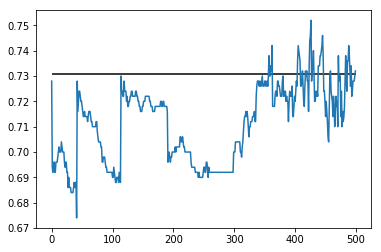

In [0]:
print(TT)
plt.plot(growth)
plt.hlines( ,0, len(growth))
growth[-1],NC#batch size 1, starting 500

(0.746, 0.7308000001430511)

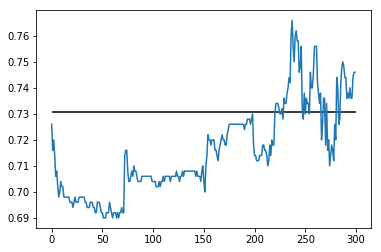

In [0]:
plt.plot(growth)
plt.hlines(NC,0, len(growth))
growth[-1],NC#batch size 2, starting 400

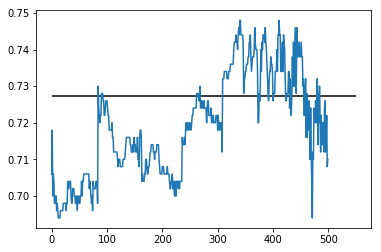

In [0]:
## from 500, bs=1
plt.plot(growth)
plt.hlines(NC,0, 550)

In [0]:
growth[-1]

0.7099999990463257

In [0]:
!ls

sample_data


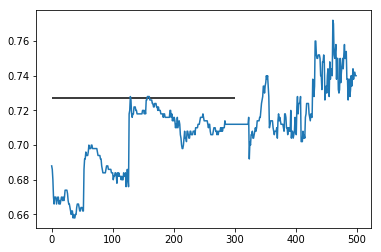

In [0]:
## from 400, bs=1
plt.plot(growth)
plt.hlines(NC,0, 300)

In [0]:
finalmodel=model

In [0]:
model.evaluate(X_test,y_test)

500/500 [==============================] - 0s 118us/step


[2.123017310142517, 0.7400000004768371]

In [0]:
NC

0.7274000005245209

In [0]:
np.concatenate([X_train,np.array(indexer(X_train,[0,10,11]))]).shape

(7146, 40)

In [0]:
model.evaluate(np.array([X_test[0],X_test[1]]),np.array([y_test[0],y_test[1]]))

In [0]:
print(model.evaluate(x=X_test,y=y_test))

In [0]:
print(model.evaluate(x=X_test,y=y_test))

In [0]:
print(model.evaluate(x=X_test,y=y_test))

In [0]:
print(model.evaluate(x=X_test,y=y_test))

## metrics

## Curriculum 

In [0]:
from keras import backend as K

def plot_learning_curve(history,annotations=True):
    x=list(range(len(history.history["loss"])))
    plt.plot(x,history.history["loss"], label='train_loss')
    ###loss###
    if "val_loss" in history.history:
        y=history.history["val_loss"]
        if(annotations==True):
            ymax = min(y)
            xpos = y.index(ymax)
            xmax = x[xpos]
            plt.annotate('min', xy=(xmax, ymax), xytext=(xmax, ymax),arrowprops=dict(facecolor='violet', shrink=0.05))
        plt.plot(x,y,label="val_loss")
        print("Overfiting after",xpos,"epochs.")
    plt.legend(loc="best")
    plt.show()
    ###acc###
    plt.plot(x,history.history["acc"], label='train_acc')
    if "val_acc" in history.history:
        y=history.history["val_acc"]
        if(annotations==True):
            ymax = y[xmax]
            plt.annotate('Best', xy=(xmax, ymax), xytext=(xmax, ymax),arrowprops=dict(facecolor='violet', shrink=0.05))
        plt.plot(x,y,label='valid_acc')
    plt.legend(loc="best")
    plt.show()
    ###f1###
    ###f1###
    if "f1" in history.history:
        plt.plot(x,history.history["f1"],label='train_f1')
        if "val_f1" in history.history:
            y=history.history["val_f1"]
            if(annotations==True):
                ymax = y[xmax]
                plt.annotate('Best', xy=(xmax, ymax), xytext=(xmax, ymax),arrowprops=dict(facecolor='violet', shrink=0.05))
            plt.plot(x,y,label='val_f1')
        plt.legend(loc="best")
        plt.show()

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
########taking